In [16]:
# Log in to the Hub
from collections import Counter
from datasets import load_dataset
from huggingface_hub import notebook_login

notebook_login()

### Getting started

In [3]:
gtzan = load_dataset("marsyas/gtzan", "all")

datasets.dataset_dict.DatasetDict

#### Features and number of records

dataset.info.features and dataset.info.splits['your_split_name'].num_examples are my go to for huggingface datasets of type datasets.arrow_dataset.Dataset, but that doesn't work here.

This data is type datasets.dataset_dict.DatasetDict, so using gtzan['train'] displays some of what we're looking for, but not the feature type or description.

This data is stored so that gtzan['train']['file'] would print 999 vertically ordered filepaths showing where the data is locally stored.

In [12]:
gtzan['train']

Dataset({
    features: ['file', 'audio', 'genre'],
    num_rows: 999
})

In [13]:
first = gtzan['train'][0]
print("Features:",
      '\n', list(first.keys()),
     '\n', [type(first[i]) for i in list(first.keys())])

Features: 
 ['file', 'audio', 'genre'] 
 [<class 'str'>, <class 'dict'>, <class 'int'>]


We already know that the 'file' feature corresponds to the local filepath and won't be used for modeling. 

'genre' is the dependent variable and 'audio' is a dictionary containing the independent variable: the audio waveform.

In [15]:
# Expand 'audio'
first_a = first['audio'] #path, array, sampling_rate
print("Features in the audio dictionary:",
      '\n', list(first_a.keys()),
     '\n', [type(first_a[i]) for i in list(first_a.keys())])

Features in the audio dictionary: 
 ['path', 'array', 'sampling_rate'] 
 [<class 'str'>, <class 'numpy.ndarray'>, <class 'int'>]


## Timing

The source page says all records are equal length, but I'd like to understand this for myself.

Source: https://huggingface.co/datasets/marsyas/gtzan

In [22]:
array_dims = []
for record in gtzan['train']:
    array_dims.append(record['audio']['array'].shape[0])

dims = dict(Counter(array_dims))
print('We have', len(dims.keys()), 'unique recording lengths in the data.\n',
      '\n', 'The most common are:',
      '\n', Counter(array_dims).most_common(n=5))

We have 34 unique recording lengths in the data.
 
 The most common are: 
 [(661794, 640), (661504, 295), (675808, 10), (661408, 5), (661676, 4)]


#### Representing length visually

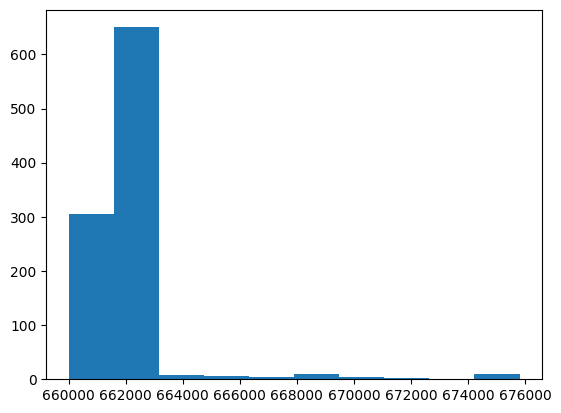

In [23]:
import matplotlib.pyplot as plt
plt.hist(array_dims)
plt.show() 

The sampling rate is 22050, so a 30.00 seconds recording would have approximately 661,500 timesteps (or 661,500 features when converted to an array). The most common length in our data, 661,794, corresponds closely.

A substantial difference would be figures less than or equal to 639,450 (29 seconds) or greater than or equal to 683,550 (31 seconds). Two records come close to the 683,550 mark, but I don't feel a strong impulse to drop them.

#### Another note on timing

This data was first published in 2001, so all recordings were made within or before that year and reflect the genre consensus of the time. If 'pop' here means 'popular' then it may not share features with future 'pop.'

Today it's 2023 and I don't remember 2001's music very well, so I will be viewing these labels with considerable bias. They reflect the standards of a time when I had little cultural awareness. Unfortunately, the source paper does not define the genre's and expects readers to intuit their meaning. 

#### Last small note on genres

Before reading the source paper, I was concerned that the demonstration model would struggle to distinguish between similar genres. This is entirely confirmed by the paper, so this will be our challenge as well. 


See data card for more backround (https://huggingface.co/datasets/marsyas/gtzan).

## Sampling Rate

In [25]:
from collections import Counter

s_rates = []
for record in gtzan['train']:
    s_rates.append(record['audio']['sampling_rate'])

s_rate_counts = dict(Counter(s_rates))
print('We have', len(s_rate_counts.keys()), 'unique sampling rate.',
      '\n', s_rate_counts)

We have 1 unique sampling rate. 
 {22050: 999}


## Genre Class Balance

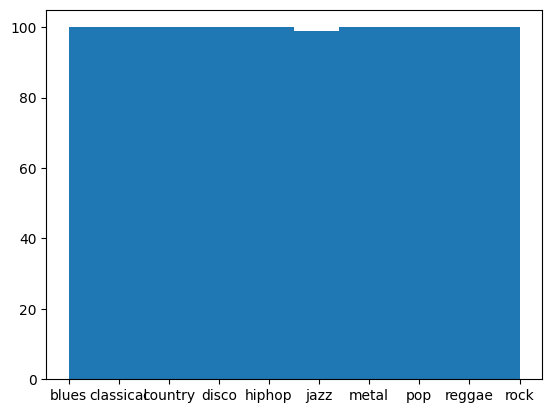

In [26]:
# What is the distribution by genre? Which classes are best represented?
id2label_fn = gtzan["train"].features["genre"].int2str

genres = []
for record in gtzan['train']:
    genres.append(id2label_fn(record['genre']))

plt.hist(genres)
plt.show() 

### There is no class imbalance.

#### Note on genre similarity

The authors define similarity as likeness of "rhythmic structure and musical surface" (Tzanetakis et al 2001). Said differently, they group songs based on having similar beats and similar sounds. They give the obvious example of hip hop and classical having completely dissimilar "surfaces." It's easy to imagine why since those songs are produced using entirely different instruments.

#### Note on new class labels

Reggae, blues and metal are not included in the original paper, so they may be later additions. 'Pop' is not defined in the original paper and also isn't reported in their Genre Classification exercise. 

#### Note on vocals

I wasn't sure if all records were instrumentation-only (or just the sample I listened to), but the paper confirms they included vocalization. They comment that pre-2001 research was able to distinguish between instruments, so using vocalization as the only feature it would be easy to distinguish hip hop and classical for example. 

#### Note on accuracy and genre

In Tzanetakis et al the model accuracy for jazz and rock are less than 50%. They give an explanation that the "boundaries" for these genres are "fuzzier" than others. I would agree with this since rock is a genre that tends to move forward by borrowing from other genres, like how shortly after this paper punk music further diversified by borrowing pop vocalization and birthed 'pop punk.'

I also think "rock" is a bit broad. The 'rock' of one generation is unlike the 'rock' of the next and this typically gives rise to subgenre labels (some tongue-in-cheek like "dad rock.") I see part of my bias is the number of genres I can name and the vast increase in genres since 2001. 

#### First hypothesis

I want to test the hypothesis that the model used in the Huggingface example was performing poorly on certain genres because of their similarity. I hypothesize their attention-based model struggles when it has found important features that could be applied correctly to both genre labels.

Sources:
- https://huggingface.co/learn/audio-course/chapter4/fine-tuning
- https://ismir2001.ismir.net/pdf/tzanetakis.pdf (Tzanetakis et al 2001)

### Modelling

I want to try a different kind of model based on similarity between waveforms. I think this is a simpler baseline than the transformer in the example. This kind of model does not employ attention and masking, so all features are equally important. I want to start there.  

In [9]:
# Divide the data
gtzan = gtzan["train"].train_test_split(seed=425, shuffle=True, test_size=0.1)

Loading cached split indices for dataset at C:\Users\wrona\.cache\huggingface\datasets\marsyas___gtzan\all\0.0.0\701395d625fb4762c27eef42c9488d843cc15869b399f7d207b07306a8b09762\cache-3a5659c6871516d5.arrow and C:\Users\wrona\.cache\huggingface\datasets\marsyas___gtzan\all\0.0.0\701395d625fb4762c27eef42c9488d843cc15869b399f7d207b07306a8b09762\cache-f88dab78a49ad137.arrow


In [10]:
'''
it requires a dict, so i have to update the whole thing to return a dict
if each record is also a dict (and it is), then it loops over them and needs a dict back

'''

pad_to_length = np.amax(array_dims)

def pad_silence(example):
    if example['audio']['array'].shape[0] == pad_to_length:
        return example['audio']['array']
    else:
        example['audio']['array'] = np.pad(example['audio']['array'], (np.abs(example['audio']['array'].shape[0] - pad_to_length)),mode='constant', constant_values=0)
        return example['audio']['array']

train = gtzan["train"].map(pad_silence)
train[0]['audio']['array'].shape

NameError: name 'np' is not defined

In [11]:
#### EXAMPLE

from datasets import load_dataset
dataset = load_dataset("squad", split="train")
dataset.features

flat_dataset = dataset.flatten()
flat_dataset

def add_prefix(example):
    example["sentence1"] = 'My sentence: ' + example["sentence1"]
    return example

updated_dataset = small_dataset.map(add_prefix)
updated_dataset["sentence1"][:5]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Dataset squad downloaded and prepared to C:/Users/wrona/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453. Subsequent calls will reuse this data.


NameError: name 'small_dataset' is not defined

In [ ]:
updated_dataset = small_dataset.map(add_prefix)
updated_dataset["sentence1"][:5]

In [ ]:
list(range(len(gtzan["train"])+1))

In [49]:
# Pad arrays to equal length
pad_to_length = np.amax(array_dims)

for i in range(len(gtzan["train"])+1):
    try:
        gtzan["train"][i]['audio']['array'] = np.pad(gtzan["train"][i]['audio']['array'], (np.abs(gtzan["train"][i]['audio']['array'].shape[0] - pad_to_length)),mode='constant', constant_values=0)
    except:
        print('Done. OOB')

Done. OOB


In [54]:
gtzan["train"][0]['audio']['array'].shape

(661794,)

In [55]:
np.amax(array_dims)

675808

In [51]:
from numpy import linalg as LA

train_set = gtzan['train']
ts_records = len(train_set)
pairwise_l2_norms = {}

for i in range(ts_records+1):
    for j in range(1,ts_records+1):
        print(i,j)
        pairwise_l2_norms[(i,j)] = LA.norm(train_set[i]['audio']['array'] - train_set[j]['audio']['array'])


0 1
0 2


ValueError: operands could not be broadcast together with shapes (661794,) (661504,) 

In [42]:
LA.norm(gtzan['train'][0]['audio']['array'] - gtzan['train'][1]['audio']['array'])

99.65081412195062

In [53]:
len(gtzan['train'])

809

In [ ]:
# Evaluation
import evaluate

accuracy = evaluate.load("accuracy")